# Explore here

It's recommended to use this notebook for exploration purposes.

        Date  Revenue
0 2024-03-31    21301
1 2023-12-31    25167
2 2023-09-30    23350
3 2023-06-30    24927
4 2023-03-31    23329
('2024-03-31 00:00:00', 21301)
('2023-12-31 00:00:00', 25167)
('2023-09-30 00:00:00', 23350)
('2023-06-30 00:00:00', 24927)
('2023-03-31 00:00:00', 23329)
('2022-12-31 00:00:00', 24318)
('2022-09-30 00:00:00', 21454)
('2022-06-30 00:00:00', 16934)
('2022-03-31 00:00:00', 18756)
('2021-12-31 00:00:00', 17719)
('2021-09-30 00:00:00', 13757)
('2021-06-30 00:00:00', 11958)
('2021-03-31 00:00:00', 10389)
('2020-12-31 00:00:00', 10744)
('2020-09-30 00:00:00', 8771)
('2020-06-30 00:00:00', 6036)
('2020-03-31 00:00:00', 5985)
('2019-12-31 00:00:00', 7384)
('2019-09-30 00:00:00', 6303)
('2019-06-30 00:00:00', 6350)
('2019-03-31 00:00:00', 4541)
('2018-12-31 00:00:00', 7226)
('2018-09-30 00:00:00', 6824)
('2018-06-30 00:00:00', 4002)
('2018-03-31 00:00:00', 3409)
('2017-12-31 00:00:00', 3288)
('2017-09-30 00:00:00', 2985)
('2017-06-30 00:00:00', 2790)
('2017-03-31 0

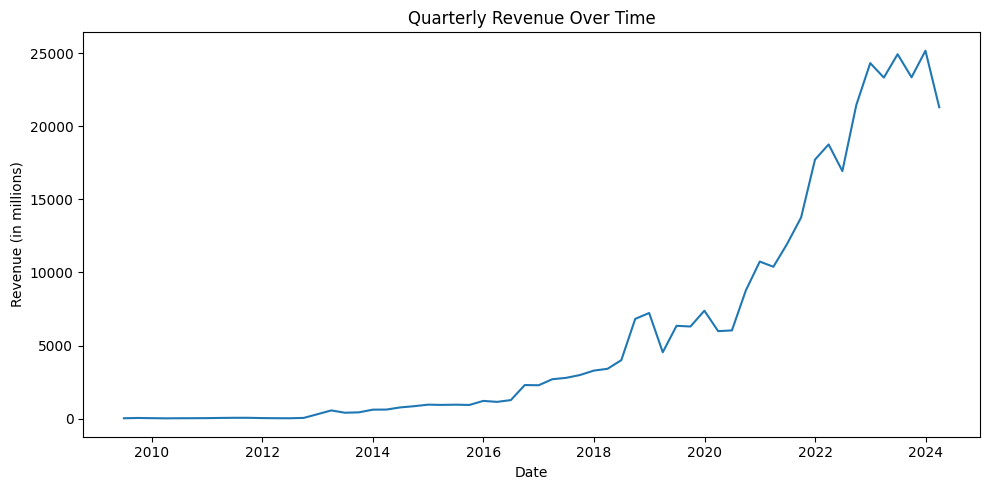

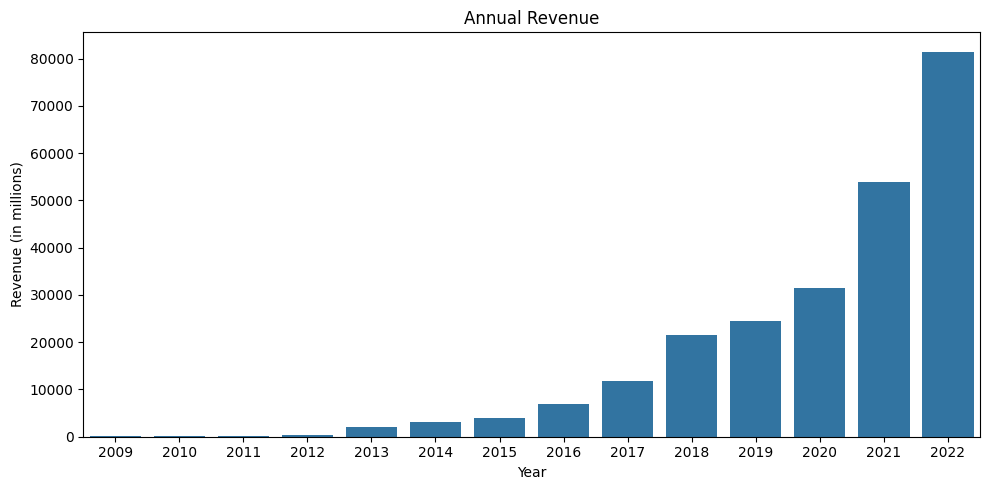

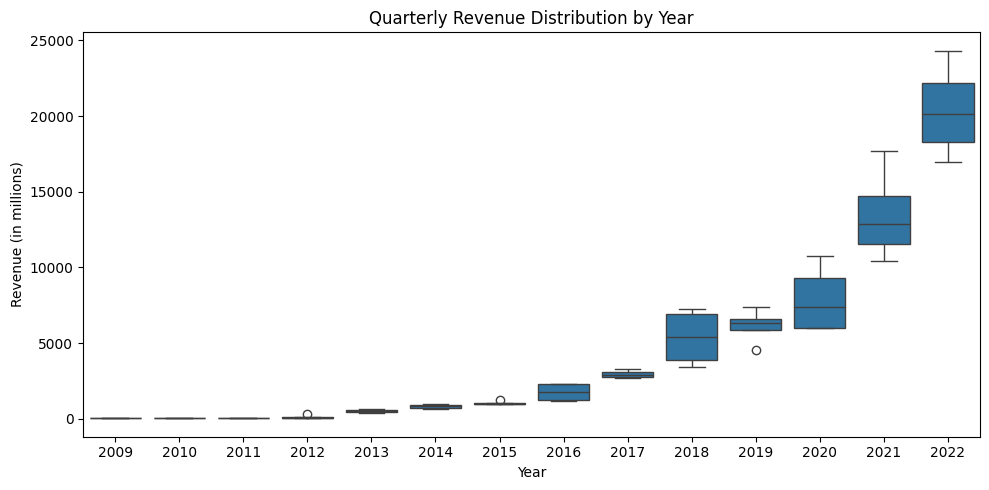

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# URL of the webpage to scrape
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"

# Add headers to simulate a browser visit to avoid 403 Forbidden error
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Send a GET request to the URL with headers
response = requests.get(url, headers=headers)
html_data = response.text

# Parse HTML content
soup = BeautifulSoup(html_data, 'html.parser')

# Find all tables on the webpage
tables = soup.find_all('table')

# Identify the table with quarterly revenue data
for table in tables:
    if 'Tesla Quarterly Revenue' in table.text:
        revenue_table = table
        break

# Extract data from the table
rows = revenue_table.find_all('tr')
data = []

for row in rows[1:]:  # Skip the header row
    cols = row.find_all('td')
    if len(cols) == 2:
        date = cols[0].text.strip()
        revenue = cols[1].text.strip().replace('$', '').replace(',', '')
        data.append([date, revenue])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Date', 'Revenue'])

# Clean up the Revenue column
df['Revenue'] = df['Revenue'].replace({'': '0'}).astype(int)

# Optionally, drop rows with zero revenue or any other specific conditions
df = df[df['Revenue'] > 0]

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print(df.head())

# Connect to SQLite database (create it if not exists)
conn = sqlite3.connect('tesla_revenue.db')

# Create a cursor object using cursor() method
cursor = conn.cursor()

# Create table if not exists
cursor.execute("""CREATE TABLE IF NOT EXISTS revenue (Date TEXT PRIMARY KEY, Revenue INTEGER)""")

# Clear the table before inserting new data
cursor.execute("DELETE FROM revenue")

# Insert data into the table
df.to_sql('revenue', conn, if_exists='append', index=False)

# Check the data from the database
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

# Commit changes
conn.commit()

# Close connection
conn.close()

print("Data successfully stored in SQLite database.")

# Visualization
# Connect to SQLite database and read data
conn = sqlite3.connect('tesla_revenue.db')
tesla_revenue = pd.read_sql_query("SELECT * FROM revenue", conn)
conn.close()

# Convert Date column to datetime format
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(int)

# 1. Line Plot of Quarterly Revenue Over Time
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=tesla_revenue, x="Date", y="Revenue", ax=axis)
axis.set_title('Quarterly Revenue Over Time')
axis.set_xlabel('Date')
axis.set_ylabel('Revenue (in millions)')
plt.tight_layout()
plt.show()

# 2. Bar Plot of Annual Revenue
tesla_revenue['Year'] = tesla_revenue['Date'].dt.year
tesla_revenue_yearly = tesla_revenue.groupby('Year')['Revenue'].sum().reset_index()
fig, axis = plt.subplots(figsize=(10, 5))
sns.barplot(data=tesla_revenue_yearly[tesla_revenue_yearly["Year"] < 2023], x="Year", y="Revenue", ax=axis)
axis.set_title('Annual Revenue')
axis.set_xlabel('Year')
axis.set_ylabel('Revenue (in millions)')
plt.tight_layout()
plt.show()

# 3. Box Plot of Quarterly Revenue Distribution by Year
fig, axis = plt.subplots(figsize=(10, 5))
sns.boxplot(data=tesla_revenue[tesla_revenue["Year"] < 2023], x="Year", y="Revenue", ax=axis)
axis.set_title('Quarterly Revenue Distribution by Year')
axis.set_xlabel('Year')
axis.set_ylabel('Revenue (in millions)')
plt.tight_layout()
plt.show()


